# testing again the final rpoduct

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch,VerticalPitch
from mplsoccer.dimensions import valid

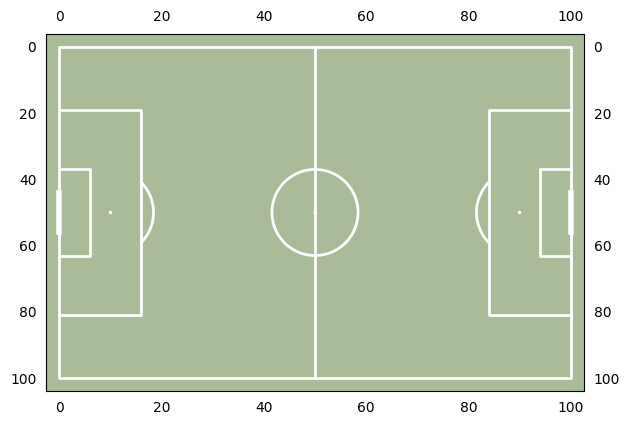

In [34]:
pitch = Pitch(
    pitch_type='wyscout',
      axis=True,
        label=True,
        pitch_color='#aabb97', 
        line_color='white',
        stripe_color='#c2d59d',
       )
fig,ax = pitch.draw()

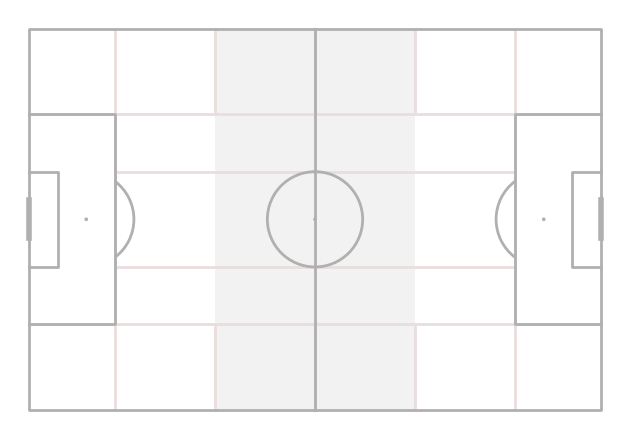

In [18]:
pitch = Pitch(positional=True, shade_middle=True, positional_color='#eadddd', shade_color='#f2f2f2')
fig, ax = pitch.draw()


In [ ]:
raw_excel_data = pd.read_csv("../datasets/Universitatea_Cluj_2024_2025_events.csv")
df_filtered = raw_excel_data[
    ((raw_excel_data["type.primary"]=="pass")|(raw_excel_data["type.primary"]=="shot")
    |raw_excel_data["type.secondary"].apply(lambda x: 'carry' in x))&
    (raw_excel_data["team.id"]!=60374)]

In [25]:
df_filtered = raw_excel_data[
    ((raw_excel_data["type.primary"]=="pass")|(raw_excel_data["type.primary"]=="shot")
    |raw_excel_data["type.secondary"].apply(lambda x: 'carry' in x))&
    (raw_excel_data["team.id"]!=60374)]
df_filtered.head()

,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type.primary,type.secondary,...,label,date,dateutc,status,competitionId,seasonId,roundId,gameweek,points,Home_Away
0,2555084360,5695562,1H,0,1,00:01.3,2.274430,2.555084e+09,pass,"['back_pass', 'short_or_medium_pass']",...,"Universitatea Cluj - Rapid Bucureşti, 2-2",24/05/2025 17:00,24/05/2025 15:00,Played,719,190857,4434474,10,1,Home
1,2555084372,5695562,1H,0,3,00:03.9,4.897518,2.555084e+09,pass,"['forward_pass', 'long_pass', 'loss', 'pass_to...",...,"Universitatea Cluj - Rapid Bucureşti, 2-2",24/05/2025 17:00,24/05/2025 15:00,Played,719,190857,4434474,10,1,Home
5,2555084383,5695562,1H,0,15,00:15.1,16.144151,2.555084e+09,pass,"['back_pass', 'recovery', 'counterpressing_rec...",...,"Universitatea Cluj - Rapid Bucureşti, 2-2",24/05/2025 17:00,24/05/2025 15:00,Played,719,190857,4434474,10,1,Home
6,2555084386,5695562,1H,0,18,00:18.1,19.093039,2.555084e+09,pass,"['back_pass', 'short_or_medium_pass']",...,"Universitatea Cluj - Rapid Bucureşti, 2-2",24/05/2025 17:00,24/05/2025 15:00,Played,719,190857,4434474,10,1,Home
7,2555084388,5695562,1H,0,20,00:20.5,21.548375,2.555084e+09,pass,"['lateral_pass', 'short_or_medium_pass']",...,"Universitatea Cluj - Rapid Bucureşti, 2-2",24/05/2025 17:00,24/05/2025 15:00,Played,719,190857,4434474,10,1,Home


In [30]:
def get_zone_index(x, y):
    """
    Maps pitch coordinates to a single zone index for a 6x5 grid.
    """
    GRID_ROWS = 5
    GRID_COLS = 6
    
    # Handle edge cases where coordinates are on the boundary or slightly over.
    x = max(0, min(x, 100))
    y = max(0, min(y, 100))
    
    # Calculate column and row indices based on the new grid dimensions.

    col = int(x // (100 / GRID_COLS)) 
    row = int(y // (100 / GRID_ROWS)) 
    
    # Ensure indices are within the valid range (0-5 for cols, 0-4 for rows).
    col = min(col, GRID_COLS - 1)
    row = min(row, GRID_ROWS - 1)
    
    # Return a grid coordinates
    return row * GRID_COLS + col

In [33]:
import numpy as np
import pandas as pd
from mplsoccer import VerticalPitch, FontManager
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe

# --- Step 1: Define the xT grid and Positional Zones ---
# In this approach, we pre-define the specific zones of the pitch
# and assign a conceptual xT value to each.
# This mimics a 'Juego de Posicion' or 'Zonal' model where certain areas
# are known to be more dangerous.
# The keys of the dictionary are the labels for the zones, and the values
# are the representative xT values.
positional_xt_values = {
    'DL': 0.04, 'DCL': 0.06, 'DCR': 0.01,
    'ML': 0.07, 'MCL': 0.09, 'MCR': 0.07, 'MR': 0.07,
    'AMCL': 0.07, 'AMCR': 0.08,
    'AL': 0.06, 'AC': 0.03, 'AR': 0.05,
    'SBL': 0.04, 'SBC': 0.05, 'SBR': 0.03,
    'GBL': 0.05, 'GBC': 0.02, 'GBR': 0.01
}


# --- Step 2: Update the `calculate_event_xt` function ---
# This function will now use the positional_xt_values dictionary.
def get_zone_from_coords_pos(x, y):
    """
    Maps a pitch coordinate (x, y) to a specific, named zone.
    This is based on the grid from the 'Juego de Posicion' heatmap,
    with refactored logic for improved readability.
    
    Args:
        x (float): The x-coordinate (0-100).
        y (float): The y-coordinate (0-100).
        
    Returns:
        str: The label of the zone (e.g., 'MCL', 'AMCR').
    """
    # Defensive line
    if x <= 20:
        if y <= 33:
            return 'DL'
        if y <= 67:
            return 'DCL'
        return 'DCR'
    # Midfield line
    if x <= 40:
        if y <= 15:
            return 'ML'
        if y <= 40:
            return 'MCL'
        if y <= 60:
            return 'MCR'
        return 'MR'
    # Attacking Midfield line
    if x <= 60:
        if y <= 40:
            return 'AMCL'
        return 'AMCR'
    # Attacking line
    if x <= 80:
        if y <= 33:
            return 'AL'
        if y <= 67:
            return 'AC'
        return 'AR'
    # Shot zones (Simpler approach)
    if x > 80:
        if y < 15:
            return 'SBL'
        if y > 85:
            return 'SBR'
        return 'SBC'
        
    return 'Unknown' # Fallback for undefined zones


def calculate_event_xt_pos(row, positional_xt_values):
    """
    Calculates the xT value for a single event based on its type and a
    pre-defined positional xT model.
    
    Args:
        row (pd.Series): A single row from the DataFrame.
        positional_xt_values (dict): Dictionary with xT values for each zone.
        
    Returns:
        float: The calculated xT value for the event.
    """
    event_type = row["type.primary"]
    
    # Logic for passes and carries
    if event_type == "pass" or 'carry' in row["type.secondary"]:
        start_x, start_y = row["location.x"], row["location.y"]
        if event_type == "pass":
            end_x, end_y = row["pass.endLocation.x"], row["pass.endLocation.y"]
        else: # This is a carry
            end_x, end_y = row["carry.endLocation.x"], row["carry.endLocation.y"]
            
        start_zone = get_zone_from_coords_pos(start_x, start_y)
        end_zone = get_zone_from_coords_pos(end_x, end_y)
        
        start_xt_value = positional_xt_values.get(start_zone, 0)
        end_xt_value = positional_xt_values.get(end_zone, 0)
        
        return end_xt_value - start_xt_value
        
    # Logic for shots
    elif event_type == "shot":
        return row["shot.xg"]
        
    return 0

# --- Step 3: Applying the function to your DataFrame ---
# Create some sample data that matches your columns to test the function.
data = {'type.primary': ['pass', 'carry', 'shot', 'pass'],
        'type.secondary': ['', 'carry', '', ''],
        'location.x': [80, 70, 90, 60],
        'location.y': [10, 25, 50, 40],
        'pass.endLocation.x': [90, np.nan, np.nan, 70],
        'pass.endLocation.y': [20, np.nan, np.nan, 50],
        'carry.endLocation.x': [np.nan, 80, np.nan, np.nan],
        'carry.endLocation.y': [np.nan, 35, np.nan, np.nan],
        'shot.xg': [np.nan, np.nan, 0.35, np.nan]}
df_filtered = pd.DataFrame(data)

# Now, we apply our function to create the new 'xT' column.
# The `SettingWithCopyWarning` is often caused by chaining operations.
# The most reliable way to add a column is to apply the function directly
# to a full DataFrame, not a slice. Your current code is good, but
# if you were filtering and then applying in a single line, it could
# trigger this warning. For example:
# my_data[my_data['team'] == 'U Cluj']['xT'] = ...  # This would trigger the warning

# The code you selected is actually correctly written and should not trigger
# the warning if `df_filtered` is a new DataFrame. The warning likely came
# from how you created `df_filtered` initially.

# Correct way to filter and create a new DataFrame to avoid the warning
df_filtered = raw_excel_data[
    ((raw_excel_data["type.primary"]=="pass") | (raw_excel_data["type.primary"]=="shot")
    | raw_excel_data["type.secondary"].apply(lambda x: 'carry' in x)) &
    (raw_excel_data["team.id"]!=60374)
].copy() # The `.copy()` here is the key to preventing the warning.

df_filtered['xT'] = df_filtered.apply(
    lambda row: calculate_event_xt_pos(row, positional_xt_values), axis=1)

print("DataFrame with new 'xT' column:")
print(df_filtered[['type.primary', 'type.secondary', 'location.x', 'location.y', 'xT']])


DataFrame with new 'xT' column:
      type.primary                                     type.secondary  \
0             pass              ['back_pass', 'short_or_medium_pass']   
1             pass  ['forward_pass', 'long_pass', 'loss', 'pass_to...   
5             pass  ['back_pass', 'recovery', 'counterpressing_rec...   
6             pass              ['back_pass', 'short_or_medium_pass']   
7             pass           ['lateral_pass', 'short_or_medium_pass']   
...            ...                                                ...   
68066         pass           ['lateral_pass', 'short_or_medium_pass']   
68067         pass  ['forward_pass', 'long_pass', 'loss', 'pass_to...   
68084         pass   ['lateral_pass', 'loss', 'short_or_medium_pass']   
68088         pass                           ['short_or_medium_pass']   
68091         pass  ['cross', 'lateral_pass', 'loss', 'pass_to_pen...   

       location.x  location.y    xT  
0            49.0        50.0 -0.01  
1            34